In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
 plt.plot(history.history[metric])
 plt.plot(history.history['val_'+metric], '')
 plt.xlabel("Epochs")
 plt.ylabel(metric)
 plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"It was so terrible. It wasn't fun to watch at all. Even the scene where the girl is using a vibrator, even that's not fun to watch in this movie. I say again, the scene where a girl is masturbating with a vibrator is not even fun to watch. Or maybe if that was the only part of the movie that you watched, just girl on couch using a vibrator. Maybe they should have just released that one scene in theaters, maybe then the movie would be enjoyable on a certain level. My advice, fast forward to that point, watch it, rewind the movie, watch it again, rewind, repeat. Maybe you could enjoy yourself for 2 hours that way. This movie ranks alongside I spit on your grave and Doom generation in the category of worst movies that I have ever seen."
 b'the more i think about it, there was nothing redeeming about this<br /><br />movie. i saw it 9 months ago, so my memory might have made it<br /><br />worse than it was, but i do know it was at least as bad as a 4 out of<br /><br />10. <br /><

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[  9,  14,  38, ...,   0,   0,   0],
       [  2,  52,  10, ...,   0,   0,   0],
       [694, 175, 316, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"It was so terrible. It wasn't fun to watch at all. Even the scene where the girl is using a vibrator, even that's not fun to watch in this movie. I say again, the scene where a girl is masturbating with a vibrator is not even fun to watch. Or maybe if that was the only part of the movie that you watched, just girl on couch using a vibrator. Maybe they should have just released that one scene in theaters, maybe then the movie would be enjoyable on a certain level. My advice, fast forward to that point, watch it, rewind the movie, watch it again, rewind, repeat. Maybe you could enjoy yourself for 2 hours that way. This movie ranks alongside I spit on your grave and Doom generation in the category of worst movies that I have ever seen."
Round-trip:  it was so terrible it wasnt fun to watch at all even the scene where the girl is using a [UNK] even thats not fun to watch in this movie i say again the scene where a girl is [UNK] with a [UNK] is not even fun to watch or maybe if

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 5s 5s/step
[0.00590906]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 101ms/step
[0.00590907]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 53s 107ms/step - loss: 0.6359 - accuracy: 0.5744 - val_loss: 0.4952 - val_accuracy: 0.7984
Epoch 2/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3951 - accuracy: 0.8205 - val_loss: 0.3633 - val_accuracy: 0.8396
Epoch 3/10
391/391 [==============================] - 27s 70ms/step - loss: 0.3424 - accuracy: 0.8524 - val_loss: 0.3414 - val_accuracy: 0.8521
Epoch 4/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3227 - accuracy: 0.8611 - val_loss: 0.3383 - val_accuracy: 0.8417
Epoch 5/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3153 - accuracy: 0.8650 - val_loss: 0.3324 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3095 - accuracy: 0.8674 - val_loss: 0.3425 - val_accuracy: 0.8271
Epoch 7/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3064 - accuracy: 0.8674 - val_loss: 0.3292 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 13s 33ms/step - loss: 0.3190 - accuracy: 0.8531
Test Loss: 0.3189719021320343
Test Accuracy: 0.8531200289726257


(0.0, 0.6526173233985901)

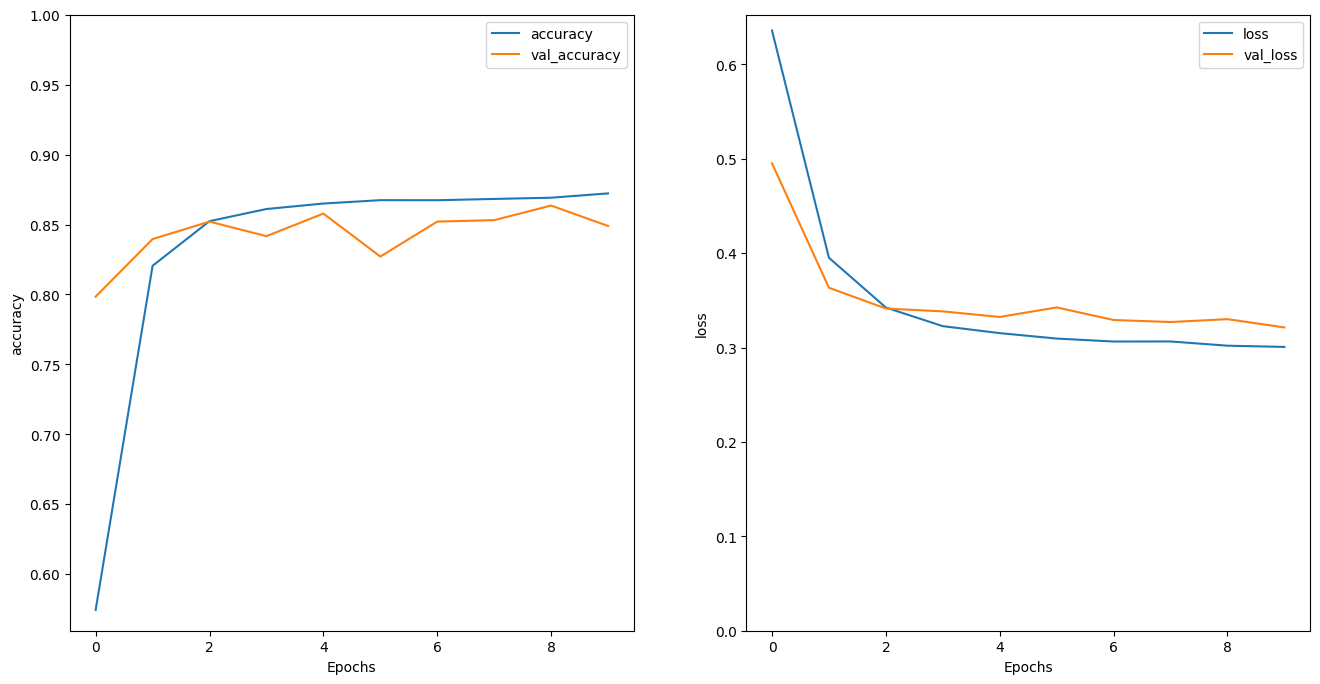

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 87s 172ms/step - loss: 0.6151 - accuracy: 0.5952 - val_loss: 0.4792 - val_accuracy: 0.7161
Epoch 2/10
391/391 [==============================] - 51s 130ms/step - loss: 0.3832 - accuracy: 0.8295 - val_loss: 0.3630 - val_accuracy: 0.8526
Epoch 3/10
391/391 [==============================] - 51s 131ms/step - loss: 0.3349 - accuracy: 0.8566 - val_loss: 0.3338 - val_accuracy: 0.8500
Epoch 4/10
391/391 [==============================] - 50s 126ms/step - loss: 0.3195 - accuracy: 0.8632 - val_loss: 0.3303 - val_accuracy: 0.8583
Epoch 5/10
391/391 [==============================] - 50s 128ms/step - loss: 0.3128 - accuracy: 0.8674 - val_loss: 0.3288 - val_accuracy: 0.8464
Epoch 6/10
391/391 [==============================] - 50s 127ms/step - loss: 0.3063 - accuracy: 0.8691 - val_loss: 0.3216 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 51s 130ms/step - loss: 0.3079 - accuracy: 0.8669 - val_loss: 0.3188 - val_ac

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 23s 59ms/step - loss: 0.3190 - accuracy: 0.8567
Test Loss: 0.3189736008644104
Test Accuracy: 0.8566799759864807


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.710361]]


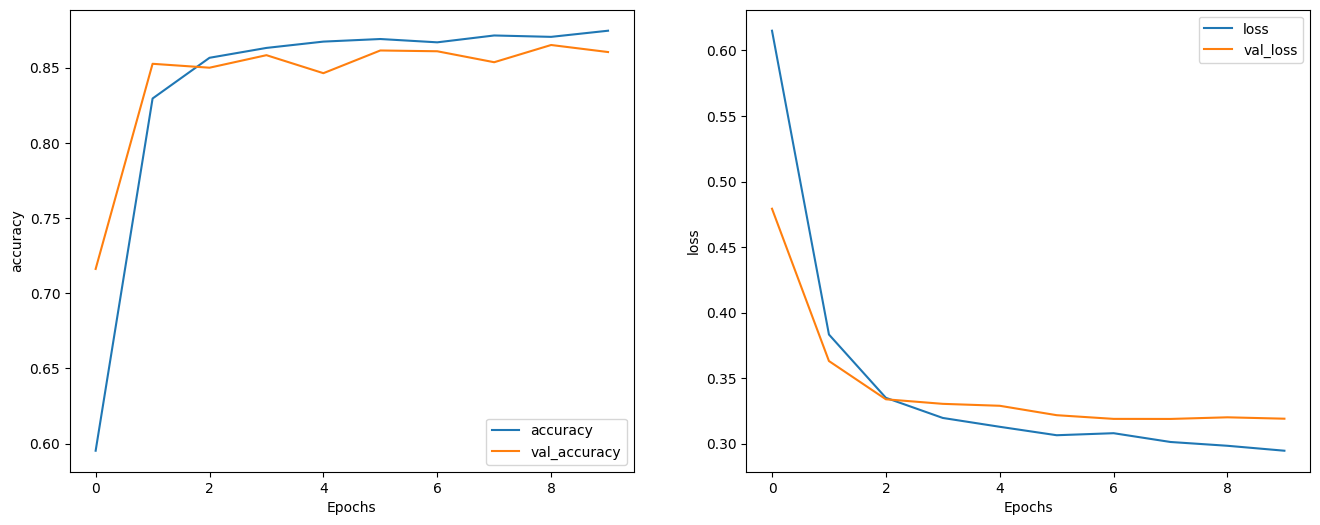

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')